In [1]:
# import user defined function
from src.eda_functions import get_info, ut_standard_col_name, show_dist_mean_mode

from src.model_functions import evaluate_classification, cv_bestK, evaluate_knn
from src.viz import plot_train_test_confusion_matrix, show_cv_results, show_cv_best_accuracy_box_plot, plot_3D_class

# import standard processing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import numpy as np

# import sci-kit learn methods
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from src.model_functions import evaluate_classification
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler


# visualisation 3D
import plotly.express as px

# random seed
RANDOM_SEED = 19

# 1. Exploratory Data Analysis

In this section we are going to explore the dataset. First of all we need to check if the dataset has the same number of independet variabile as in the documentation of the exercise.

The input dataset has 500 observation and 6 features. Instead, the metadata describe 7 different features. In particular, `Acidità (1-10)` is missing at all. However, from the description we can deduct it corresponds to the complementary of `Dolcezza (1-10)`. However, in that case the features will be completely dependent and can produce errors of multicollinearity in the models. Hence, it is not necessary to compute the additional feature `Acidità (1-10)`.

## 1.1 Duplicates

The daset does not present duplicated rows. Hence, there is no need to deel with these cases.

## 1.2 Summary information

The function `get_info()` creates a `pandas.DataFrame` with useful information for each variable in the dataset.

In particular, the result shows that there are **no missing values** in the input dataset. Hence, it is not necessary to impute values for missing values. However, the feature `durezza_buccia_(1-10)` should have values in the interval 1 to 10, but the maximum value among data is $13.72$. It is necessary to investigate further those anomalies.

The independent variables have different unit of measurement, thus, it is necessary to preprocess the features in order to avoid the case where the model gives more importance to a feature respect to another one due to the magnitude.

### 1.2.1 Anomalies



## 1.3 Balanced dataset

Another issue in classification problems can be due to unbalanced data in the target. Therefore, the cell below use the function `value_counts()` for the target variable `frutto` and the result shows the dataset is perfectly balanced.

The shape of the input datset is: (500, 6)
Columns of the input dataset are: ['Frutto', 'Peso (g)', 'Diametro medio (mm)', 'Lunghezza media (mm)', 'Durezza buccia (1-10)', 'Dolcezza (1-10)']
The input dataset has 0 duplicates.

INFORMATION ABOUT THE RAW DATASET


,dtype,n_unique,nan_values,count,mean,std,min,25%,50%,75%,max
frutto,object,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peso_(g),float64,470,0,500.0,47.31344,26.768797,8.57,24.7975,42.380,68.0800,111.21
diametro_medio_(mm),float64,487,0,500.0,86.57310,64.293403,7.53,50.5100,70.450,88.8525,299.89
lunghezza_media_(mm),float64,373,0,500.0,5.29862,2.641993,1.15,2.6725,5.670,7.4550,11.14
durezza_buccia_(1-10),float64,349,0,500.0,7.43764,1.812548,3.07,6.1525,7.340,8.6150,13.72
dolcezza_(1-10),float64,305,0,500.0,3.59322,1.264899,1.25,2.5700,3.535,4.4650,6.95


There are 40 data points with a valure of feature 'durezza_buccia_(1-10)' out of range.

The anomalies are related to the following fruits:
Uva       24
Banana    15
Mela       1
Name: frutto, dtype: int64


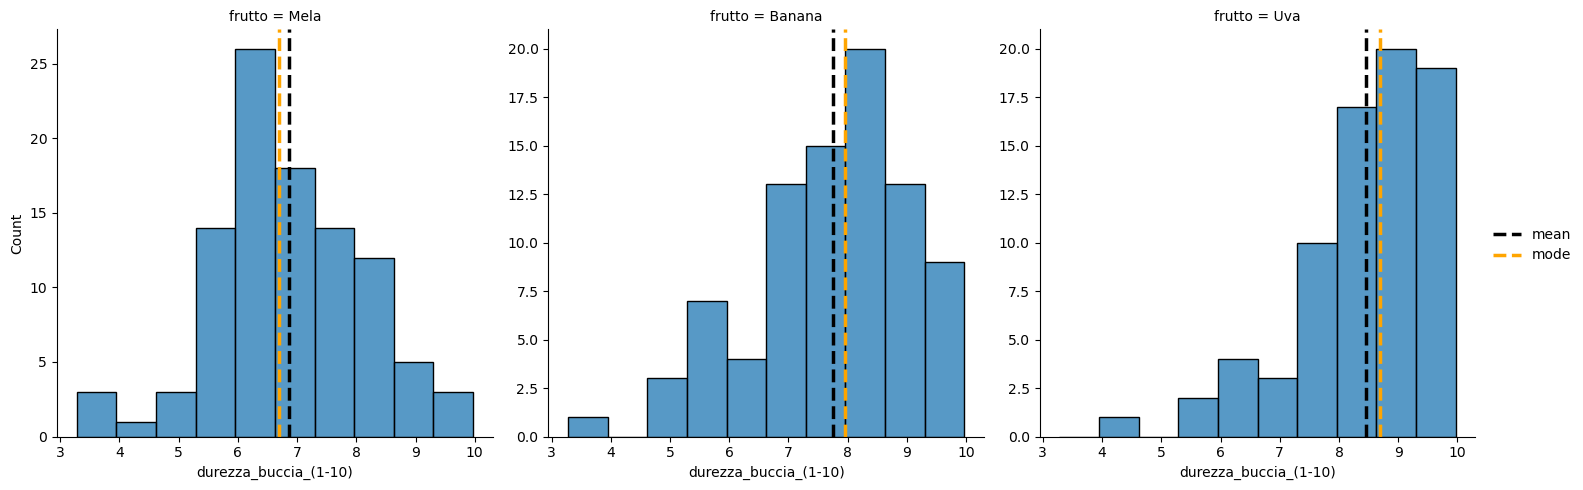

Mela       100
Banana     100
Arancia    100
Uva        100
Kiwi       100
Name: frutto, dtype: int64

In [2]:
# read data
# input_df = pd.read_csv("https://proai-datasets.s3.eu-west-3.amazonaws.com/fruits.csv")
input_df = pd.read_csv("./data/fruits.csv")

# get general information of the input dataset
print(f"The shape of the input datset is: {input_df.shape}")
print(f"Columns of the input dataset are: {input_df.columns.to_list()}")

# standardise columns names
input_df = ut_standard_col_name(input_df)

# check duplicates
print(f"The input dataset has {input_df.duplicated().sum()} duplicates.")

# get initial information of input DataFrame
info_input_df = get_info(input_df)
print("\nINFORMATION ABOUT THE RAW DATASET")
display(info_input_df)

# investigate anomalies
anomalies_df = input_df.copy()
anomalies_df = anomalies_df[anomalies_df["durezza_buccia_(1-10)"]>10]

print(f"There are {anomalies_df.shape[0]} data points with a valure of feature",
      "'durezza_buccia_(1-10)' out of range.")

print("\nThe anomalies are related to the following fruits:")
print(anomalies_df.frutto.value_counts())

# visualize distribution
no_anomalies_graph = show_dist_mean_mode(df=input_df[(input_df.frutto.isin(anomalies_df.frutto.unique())) &
                                                     (input_df['durezza_buccia_(1-10)']<=10)],
                                         x='durezza_buccia_(1-10)',
                                         col='frutto')
# no_anomalies_graph.fig.text(0.5, -0.01, 'Fig 1: Scatter plot of all the combinations of features.', ha='center', fontsize=16)
plt.show()

# set anomalies as missing values
input_df.loc[input_df['durezza_buccia_(1-10)']>10, 'durezza_buccia_(1-10)'] = np.nan

# check unbalanced target
display(input_df.frutto.value_counts())

## 1.4 Feature visualisation

Figure 1 shows all the possible combinations of features in order to show on multiple 2D scatter plots how well groups of different exotic fruits are separated. In general, `Banana` and `Uva` target are well separated by almost all the combinations except for figures 1.8 and 1.10. Instead, fruits labeled as `Mela`, `Arancia`, and `Kiwi` are not well separated for any combinations in 2D graph. However, figure 1.2 and 1.4 shows a possible separation between data points.

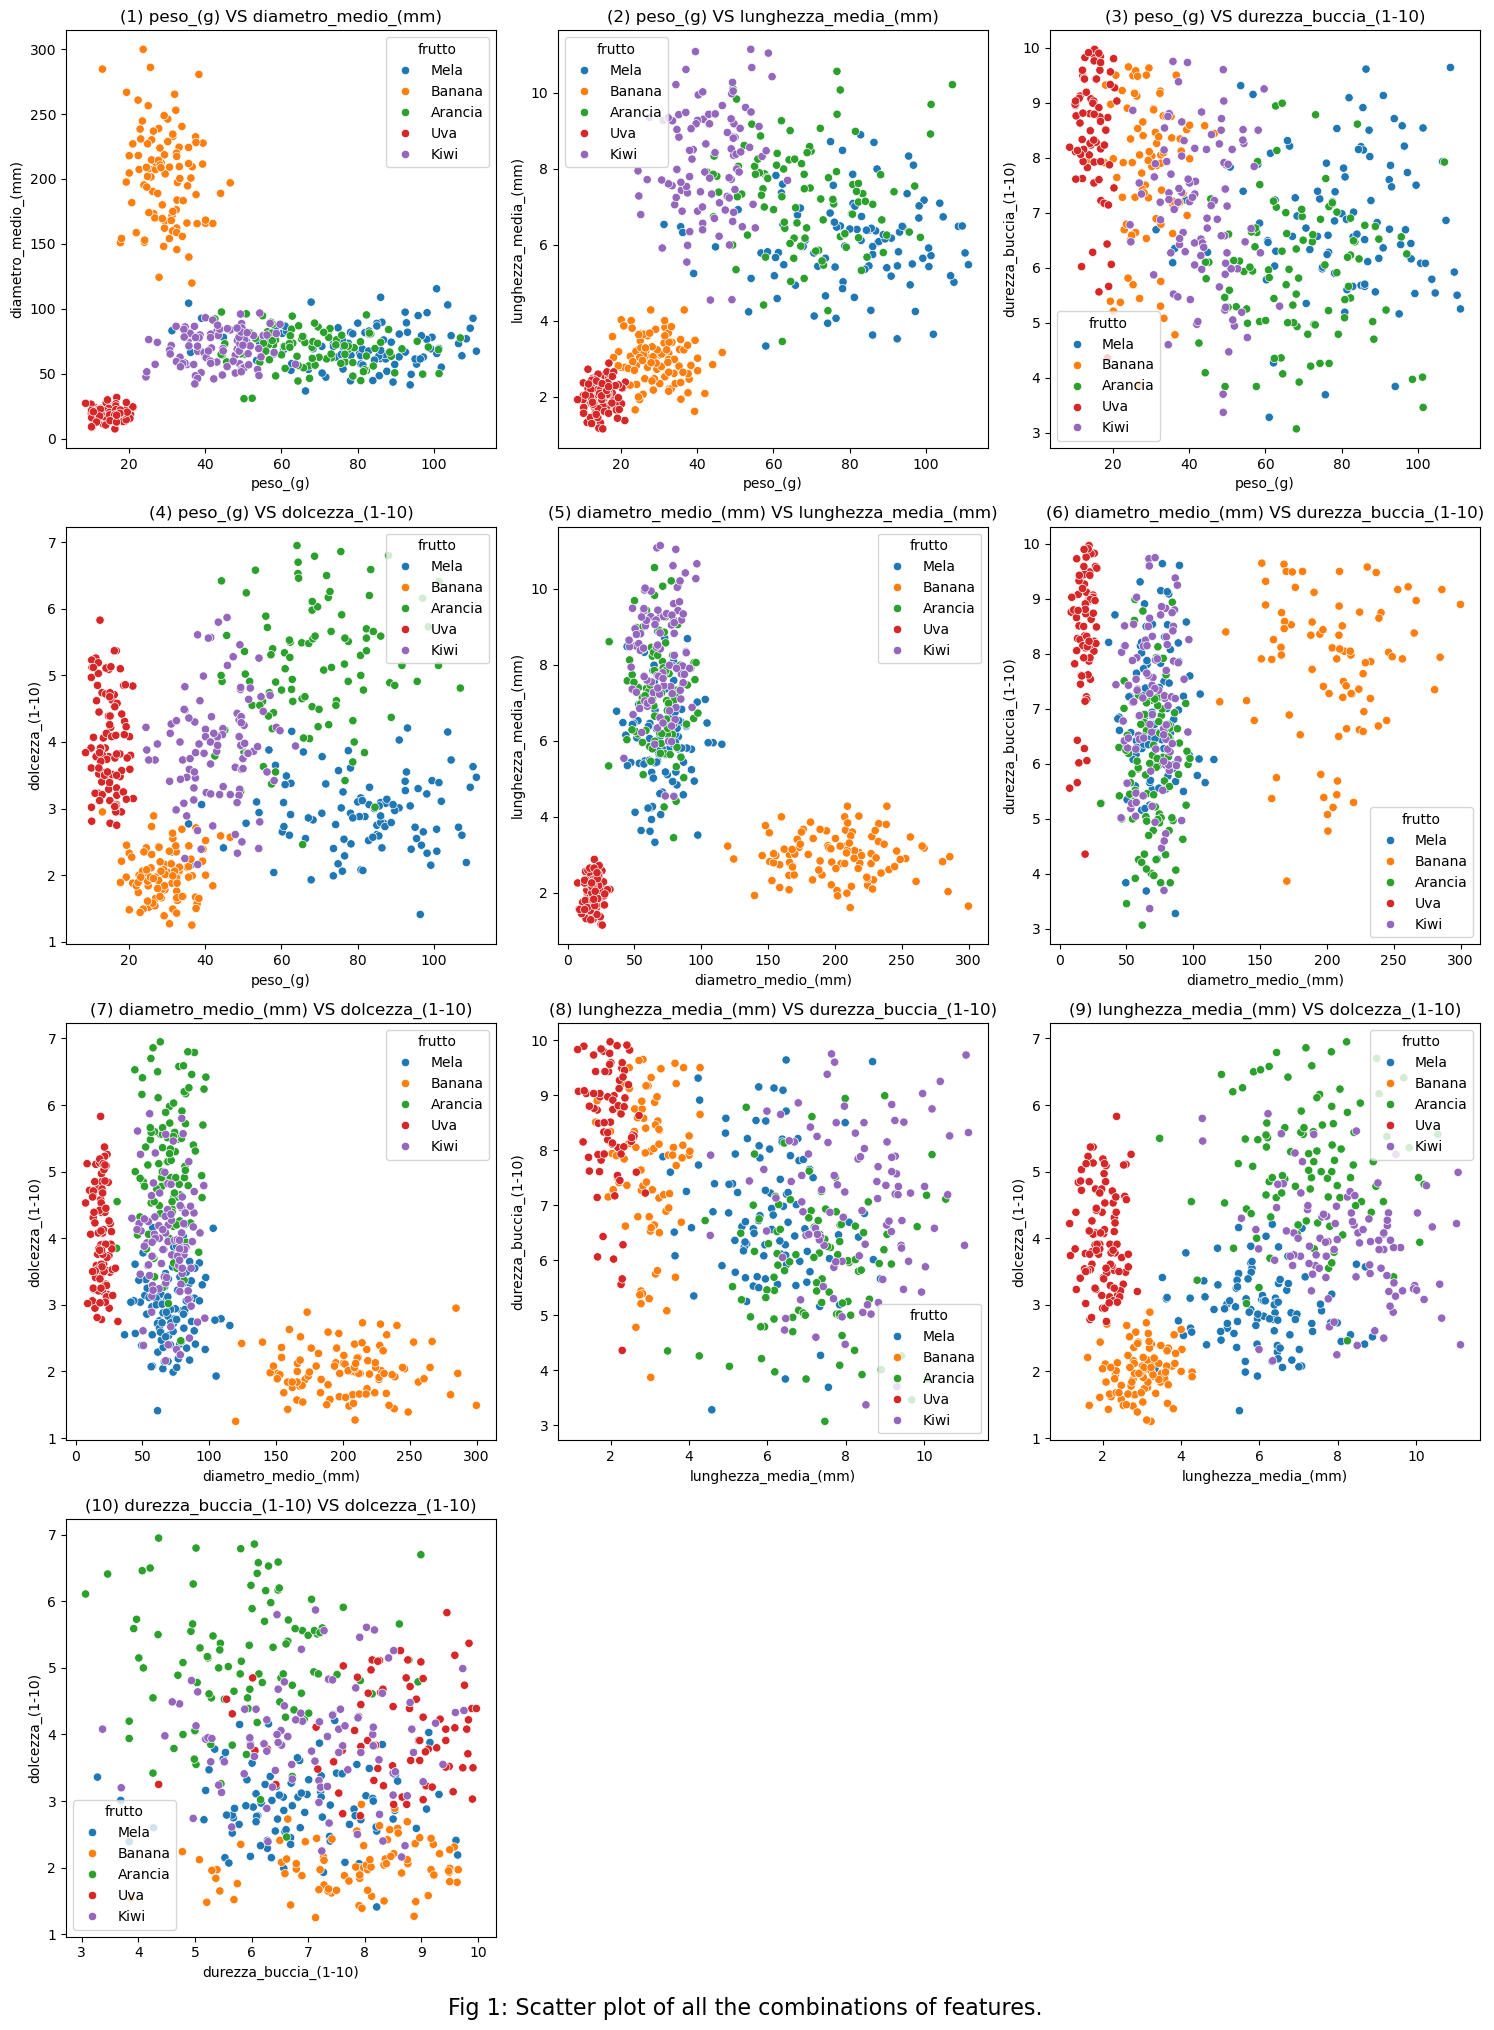

In [3]:
features_ls = list(input_df.columns)
features_ls.remove('frutto')
features_combination_ls = list(combinations(features_ls, r=2))

n_fig_per_row = 3
n_rows = int(np.ceil(len(features_combination_ls)/n_fig_per_row))

fig, axs = plt.subplots(nrows=n_rows,
                        ncols=n_fig_per_row,
                        figsize=(15, 5*n_rows),
                        tight_layout=True)

for i, ((f1, f2), ax) in enumerate(zip(features_combination_ls, axs.ravel())):
    sns.scatterplot(data=input_df, x=f1, y=f2, hue='frutto', ax=ax)
    ax.set(title=f"({i+1}) {f1} VS {f2}")

# set axis off
for ax in axs.ravel()[len(features_combination_ls):]:
    ax.set_axis_off()

fig.text(0.5, -0.01, 'Fig 1: Scatter plot of all the combinations of features.', ha='center', fontsize=16)
plt.show()

# 2 Model development

This section presents the different steps to create and validate a k-nearest neighbors (aka KNN) classfier.

The topics are:
* Preprocessing and creation of training and test set.
* Cross-Validation to find the best number of neighbours.
* Best model application.

## 2.1 Preprocessing

The KNN is a non parametric algorithm and it does not make any assumption on the distribution of the data. In the case the model does not make any assumption about the distribution is a good practice to normalize the data.

The function `MinMaxScaler()` of sci-kit learn is used to satisfy that requirement. In particular, the transformer is fitted over the training set and only applied on the test set in order to avoid a data lekeage error. The procedure creates two new variables `X_train_processed` and `X_test_processed` in order to use the raw `X_train` for the cross validation process.

Moreover, the preprocessing include also the encoding of the target variable since for sklearn is faster to train the model. However, in this example is not a mandatory step since the dataset is very small.

In [4]:
# dictionary to encode target variable
fruits_dict = {
    'Arancia': 0,
    'Banana': 1,
    'Kiwi': 2,
    'Mela': 3,
    'Uva' : 4
}
# dictionary to decode target variable
fruits_dict_reversed = {v: k for k, v in fruits_dict.items()}

# get features and terget array
X = input_df.drop(columns=['frutto']).values
y = input_df.frutto.map(lambda x: fruits_dict[x]).values

# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=RANDOM_SEED)

# show the shape of train and test
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# preprocess data
impute_and_scale_col_index = [3]
scale_col_index = [0, 1, 2, 4]

# define a pipeline to impute missing values and normalize data
impute_and_scale_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', missing_values=np.nan)),
    ('scaler', MinMaxScaler())
])

# build column transformer to preprocess features
preprocessor = ColumnTransformer(
    transformers=[
        ('impute_and_scale', impute_and_scale_pipeline, impute_and_scale_col_index),
        ('scaler', MinMaxScaler(), scale_col_index)
    ],
    remainder='passthrough'
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train shape: (350, 5)
X_test shape: (150, 5)


## 2.2 Cross-validation

The process of cross-validation is used to identify the best paramenter `n_neighbors` over the training set. In particular, the choice is to use a **5-fold cross validation**. Hence, the training set is divided in 5 subset and one of them is used as test set and the other as training. Moreover, the preprocessing is fitted only on folds used as training.

In [5]:
# apply cross validation
N_SPLITS = 5
metrics_cv_df = cv_bestK(dataset=(X_train, y_train),
                         Ks=np.arange(1, 45, 1),
                         preprocessor=preprocessor,
                         knn_weights='uniform',
                         n_splits=N_SPLITS,
                         rnd_seed=RANDOM_SEED,
                         all_metrics=True,
                         flag_balance_splits=False)

### 2.2.1 Results

Figure 2 shows two different graph related to accuracy (Fig 2.1) and log loss (Fig 2.2). In particular, a higher value of accuracy means a good classification of the data points, instead, a lower value of the log loss means a better classificiation model. The log loss mesure the differnce between the probability to have as result a specific class and the true value for the same data point.

Figure 2.1 shows that there are three different values of number of neighbours that reach the maximum accuracy for the test sets ($n\_neighbors \in \{24, 31, 32\}$). Instead, figure 2.2 shows only a single value with the minimum value of log loss for the test sets ($n\_neighbors=20$).

The results plotted corresponds only to the average value of accuracy and log loss for the 5-fold cross validation. The best number of neighbours should be chosen looking to the variability of the performances of the cross-validation process. Figure 3 shows the box plots of models with the best value of accuracy. It is possible to see that the model with $n\_neighbors=31$ shows the lower variability of the accuracy across all the 5 folds. Hence, it should be more stable over different settings.

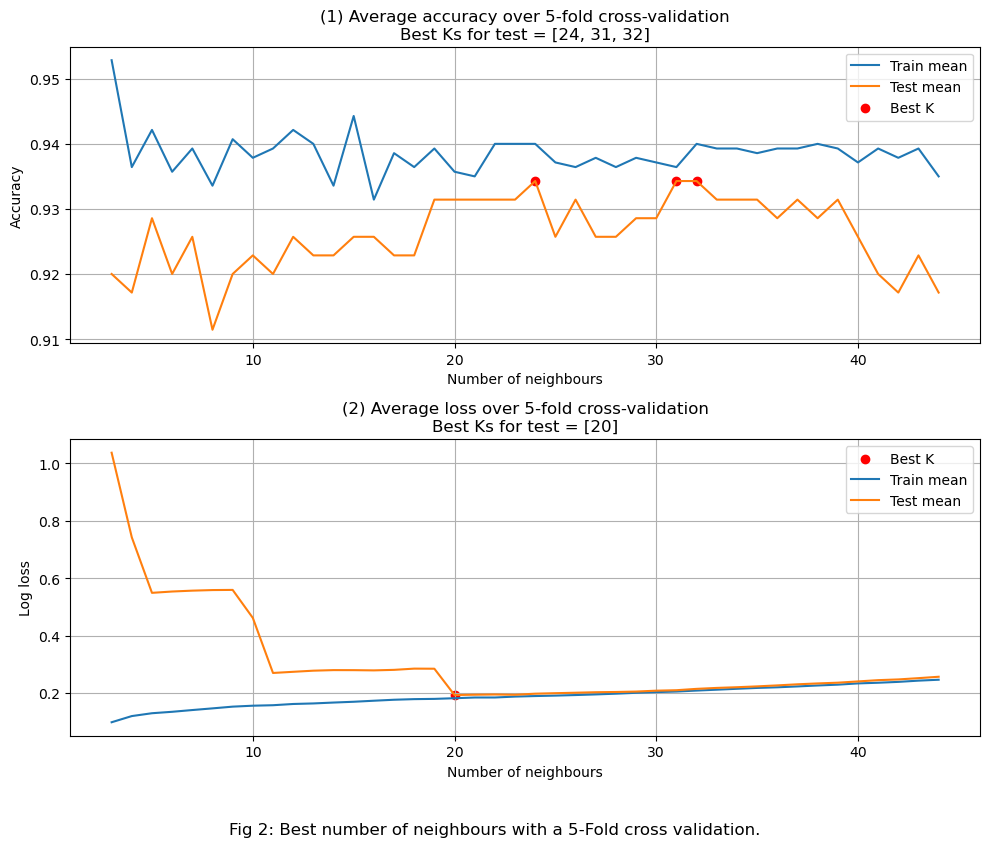

In [6]:
show_cv_results(metrics_cv_df=metrics_cv_df,
                min_neighbors=3,
                n_splits=N_SPLITS,
                fig_number=2)

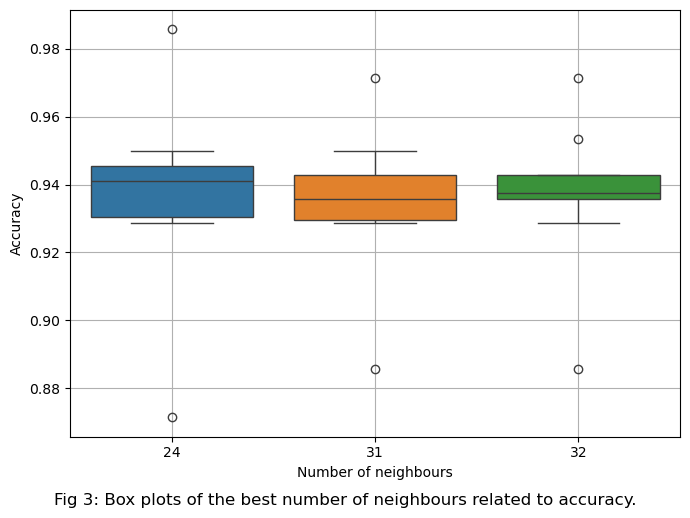

In [7]:
show_cv_best_accuracy_box_plot(metrics_cv_df=metrics_cv_df,
                               min_neighbors=5,
                               fig_number=3)

## 2.3 Final model

Section 2.2 presents the cross-validation process over the training set and evaluate the performances of multiple models. However, the performances presented are related to what the model is able to learn with a portion of the training set. Hence, it is necessary to test the possible best solution over the whole training set and the test set.

The results on the cell below presents that the model with $n\_neighbors=31$ have the best threshold between accuracy and log loss. Due to those results we decide that is the best model.

In [8]:
knn_20 = evaluate_knn(n_neighbors=20,
                      train_ds=(X_train_processed, y_train),
                      test_ds=(X_test_processed, y_test))

knn_24 = evaluate_knn(n_neighbors=24,
                      train_ds=(X_train_processed, y_train),
                      test_ds=(X_test_processed, y_test))

knn_31 = evaluate_knn(n_neighbors=31,
                      train_ds=(X_train_processed, y_train),
                      test_ds=(X_test_processed, y_test))

knn_32 = evaluate_knn(n_neighbors=32,
                      train_ds=(X_train_processed, y_train),
                      test_ds=(X_test_processed, y_test))


Number of neighbours: 20
 	TRAINING:
	- accuracy: 94.00%
 	- loss: 0.1738
 	TEST:
	- accuracy: 90.00%
 	- loss: 0.2181

Number of neighbours: 24
 	TRAINING:
	- accuracy: 94.00%
 	- loss: 0.1812
 	TEST:
	- accuracy: 91.33%
 	- loss: 0.2219

Number of neighbours: 31
 	TRAINING:
	- accuracy: 94.57%
 	- loss: 0.1901
 	TEST:
	- accuracy: 92.00%
 	- loss: 0.2277

Number of neighbours: 32
 	TRAINING:
	- accuracy: 94.57%
 	- loss: 0.1915
 	TEST:
	- accuracy: 92.00%
 	- loss: 0.2290


# 3. Conclusions

Figure 4.1 shows the confusion matrix of the model we chose with the training set. It shows the classes are not balanced. Moreover, the model does not make any error to predict `Uva` and `Banana`, that is true also in the test set (figure 4.2). That is due to the fact features separate very well those classes. In section 1.4, we have already discussed that.

Figure 5 shows a 3D plot of the features after apply the PCA of the training set. It is possible to see how even in the 3 dimensional space the classes `Arancia`, `Mela`, and `Kiwi` overlap.

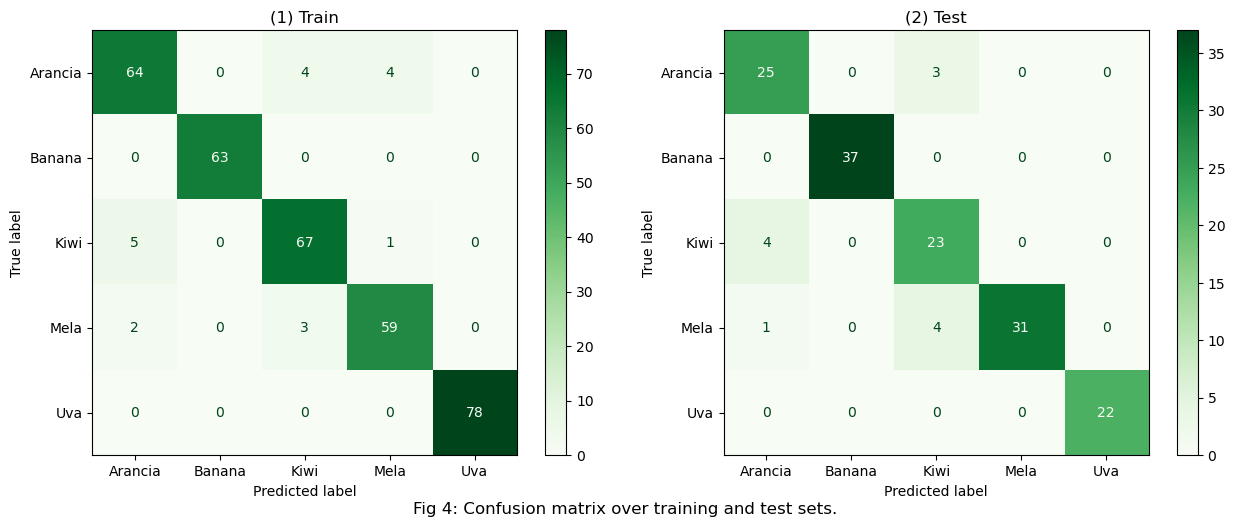

In [9]:
plot_train_test_confusion_matrix(knn_31,
                                 (X_train_processed, y_train),
                                 (X_test_processed, y_test),
                                 fig_number=4,
                                 labels=fruits_dict.keys())

In [10]:
plot_3D_class(clf_mdl=knn_31,
              dataset=(X_test_processed, y_test),
              decode_labels_dict=fruits_dict_reversed,
              flag_train=False,
              fig_number=5)

Fig 5: 3D plot of differences between predicted and true classes over the test set.


# 4. Extra

To improve the model I suggest the following methods:
1. Balance the training and test set with the parameter `stratify` in the `train_test_split` function.
2. Use the parameter `weigths='distance'` in the `KNeighboursClassifier`. That method weight points by the inverse of their distance. That is useful in case of overlapping classes such as `Mela`, `Arancia` and `Kiwi`.
3. Try different classification models such as `RandomForestClassifier`, `XGBClassifier`, `SVC`, and a simple neural network using the `MLPClassifier` of sci-kit learn.

## 4.1 Results

Figure 6 shows the result of classification over the entire dataset where the classes are balanced on both training and test. The KNN model gives an uniform weight to all the neighbours. In the case of $n\_neighbors \in {13, 14, 42}$ does not present overfitting and the accuracy is a bit higher respect to the best model without balancing classes in training and test sets. The model with $n\_neighbors=42$ has a too large number of neighbors so it is not considered as a best possible solution.



In [11]:
import copy

In [12]:
preprocessor_balanced = copy.deepcopy(preprocessor)
preprocessor_balanced

ColumnTransformer(remainder='passthrough',
                  transformers=[('impute_and_scale',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 [3]),
                                ('scaler', MinMaxScaler(), [0, 1, 2, 4])])

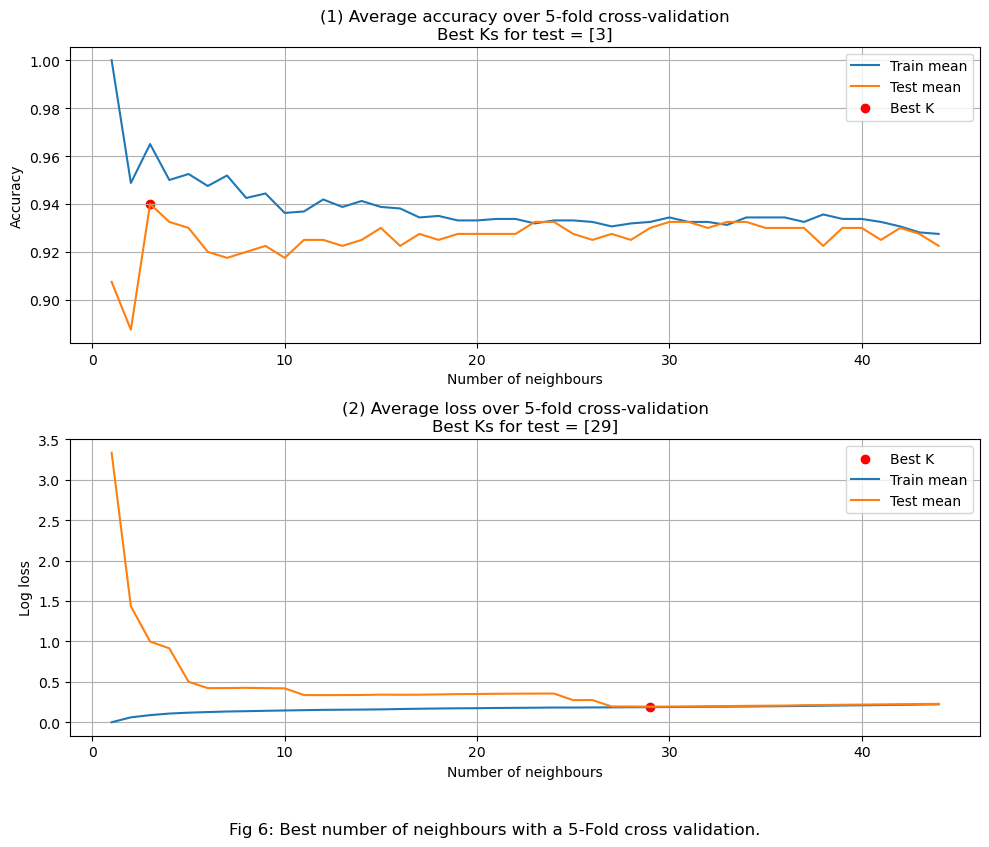

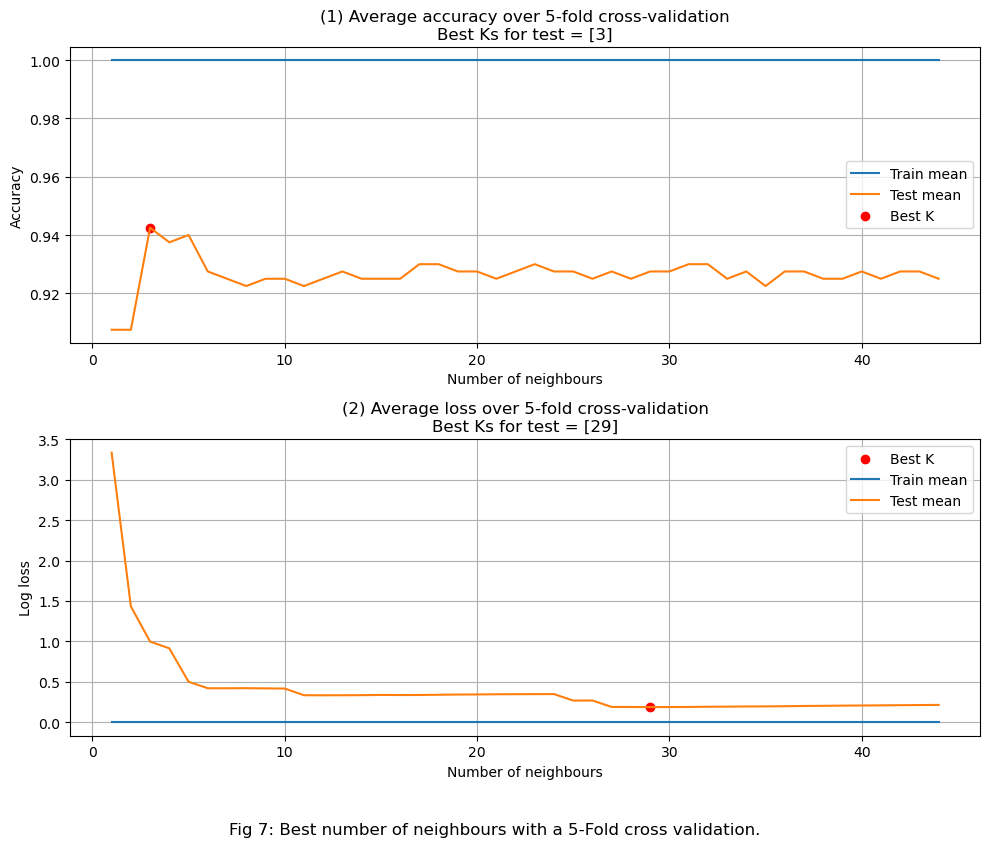

In [13]:
# split dataset into training and test set with balanced classes
X_balanced_train, X_balanced_test, y_balanced_train, y_balanced_test = train_test_split(
    X, y,
    test_size=.2,
    stratify=y,
    random_state=RANDOM_SEED)

# preprocess data
preprocessor_balanced = copy.deepcopy(preprocessor)
X_balanced_train_processed = preprocessor_balanced.fit_transform(X_balanced_train)
X_balanced_test_processed = preprocessor_balanced.transform(X_balanced_test)

metrics_balanced_cv_df = cv_bestK(
    dataset=(X_balanced_train_processed, y_balanced_train),
    Ks=np.arange(1, 45, 1),
    preprocessor=preprocessor_balanced,
    knn_weights='uniform',
    n_splits=N_SPLITS,
    rnd_seed=RANDOM_SEED,
    all_metrics=True,
    flag_balance_splits=True
)

show_cv_results(metrics_cv_df=metrics_balanced_cv_df,
                min_neighbors=1,
                n_splits=N_SPLITS,
                fig_number=6)

metrics_balanced_distance_cv_df = cv_bestK(
    dataset=(X_balanced_train_processed, y_balanced_train),
    Ks=np.arange(1, 45, 1),
    preprocessor=preprocessor_balanced,
    knn_weights='distance',
    n_splits=N_SPLITS,
    rnd_seed=RANDOM_SEED,
    all_metrics=True,
    flag_balance_splits=True
)

show_cv_results(metrics_cv_df=metrics_balanced_distance_cv_df,
                min_neighbors=1,
                n_splits=N_SPLITS,
                fig_number=7)

In [14]:
# distance weight uniform
knn_3 = evaluate_knn(n_neighbors=3,
                      train_ds=(X_balanced_train_processed, y_balanced_train),
                      test_ds=(X_balanced_test_processed, y_balanced_test),
                      knn_weight='uniform')

knn_29 = evaluate_knn(n_neighbors=29,
                      train_ds=(X_balanced_train_processed, y_balanced_train),
                      test_ds=(X_balanced_test_processed, y_balanced_test),
                      knn_weight='uniform')

# weight based on distance
knn_dst_3 = evaluate_knn(n_neighbors=3,
                      train_ds=(X_balanced_train_processed, y_balanced_train),
                      test_ds=(X_balanced_test_processed, y_balanced_test),
                      knn_weight='distance')

knn_dst_29 = evaluate_knn(n_neighbors=29,
                      train_ds=(X_balanced_train_processed, y_balanced_train),
                      test_ds=(X_balanced_test_processed, y_balanced_test),
                      knn_weight='distance')


Number of neighbours: 3
 	TRAINING:
	- accuracy: 96.75%
 	- loss: 0.0854
 	TEST:
	- accuracy: 89.00%
 	- loss: 0.8834

Number of neighbours: 29
 	TRAINING:
	- accuracy: 93.50%
 	- loss: 0.1836
 	TEST:
	- accuracy: 90.00%
 	- loss: 0.2346

Number of neighbours: 3
 	TRAINING:
	- accuracy: 100.00%
 	- loss: 0.0000
 	TEST:
	- accuracy: 89.00%
 	- loss: 0.8740

Number of neighbours: 29
 	TRAINING:
	- accuracy: 100.00%
 	- loss: 0.0000
 	TEST:
	- accuracy: 92.00%
 	- loss: 0.2246


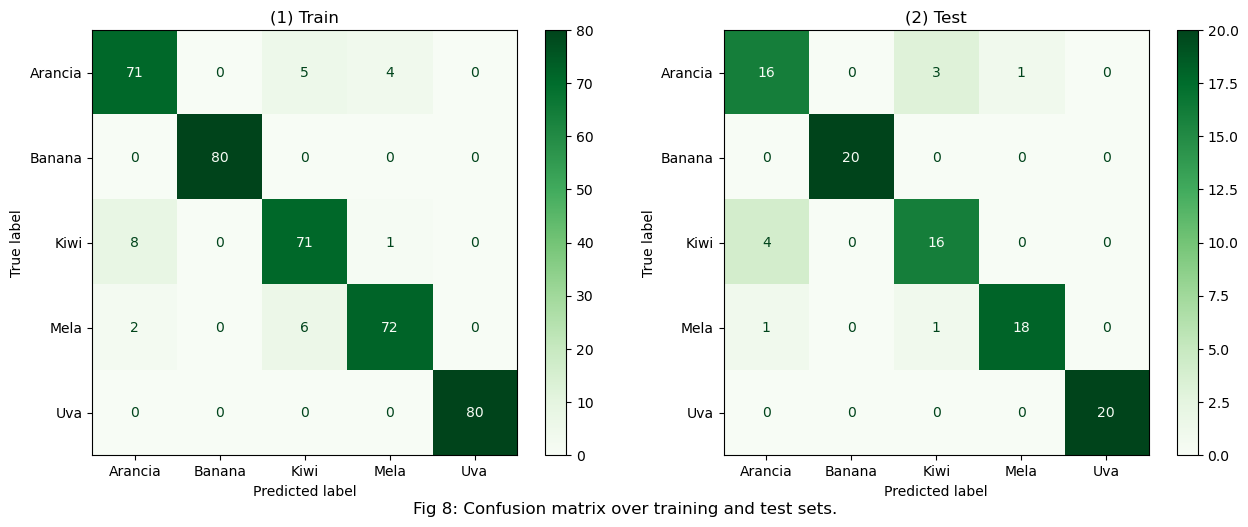

In [15]:
plot_train_test_confusion_matrix(knn_29,
                                 (X_balanced_train_processed, y_balanced_train),
                                 (X_balanced_test_processed, y_balanced_test),
                                 fig_number=8,
                                 labels=fruits_dict.keys())

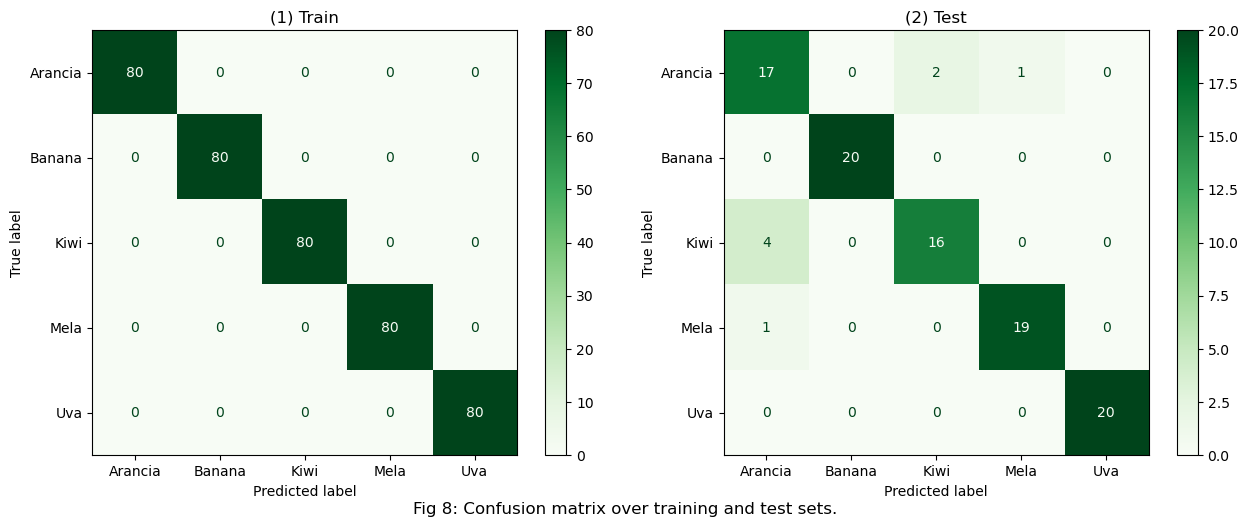

In [16]:
plot_train_test_confusion_matrix(knn_dst_29,
                                 (X_balanced_train_processed, y_balanced_train),
                                 (X_balanced_test_processed, y_balanced_test),
                                 fig_number=8,
                                 labels=fruits_dict.keys())

In [17]:
1/X_balanced_train.shape[1]

0.2

In [18]:
svc = SVC(kernel='poly', probability=True, gamma=15)

svc.fit(X_balanced_train_processed, y_balanced_train)
print(evaluate_classification(mdl=svc, dataset=(X_balanced_train_processed, y_balanced_train)))
print(evaluate_classification(mdl=svc, dataset=(X_balanced_test_processed, y_balanced_test)))

(0.97, 0.21955705838511264)
(0.94, 0.3005438652271731)


In [19]:
svc = SVC(kernel='sigmoid', probability=True, gamma=0.001)

svc.fit(X_balanced_train_processed, y_balanced_train)
print(evaluate_classification(mdl=svc, dataset=(X_balanced_train_processed, y_balanced_train)))
print(evaluate_classification(mdl=svc, dataset=(X_balanced_test_processed, y_balanced_test)))

(0.91, 1.6169605191947545)
(0.89, 1.6167154992410158)


In [20]:
svc = SVC(kernel='rbf', probability=True, gamma=17)

svc.fit(X_balanced_train_processed, y_balanced_train)
print(evaluate_classification(mdl=svc, dataset=(X_balanced_train_processed, y_balanced_train)))
print(evaluate_classification(mdl=svc, dataset=(X_balanced_test_processed, y_balanced_test)))

(0.97, 0.11047161067204916)
(0.92, 0.2354424231909201)


In [21]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 1000, 10000, 5,),
                    max_iter=10_000_000,
                    early_stopping=True,
                    random_state=RANDOM_SEED)
mlp.fit(X_balanced_train_processed, y_balanced_train)
print(evaluate_classification(mdl=mlp, dataset=(X_balanced_train_processed, y_balanced_train)))
print(evaluate_classification(mdl=mlp, dataset=(X_balanced_test_processed, y_balanced_test)))

(0.74, 0.7112478031343702)
(0.71, 0.8325755665182676)
